In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 第一个卷积层， 输入图像通道为3 , 输出的通道数为64 , 卷积核大小为3x3
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2)
        # 第二个卷积层， 输入通道数为64 , 输出的通道数为128 , 卷积核大小为3x3
        self.conv2 = nn.Conv2d(64, 128, 3)
        # 第三个卷积层， 输入通道数为16 , 输出的通道数为3256 , 卷积核大小为3x3
        self.conv3 = nn.Conv2d(128, 256, 3)
        # 第一个全连接层
        self.fc1 = nn.Linear(256 * 12 * 12, 256)
        # 第二个全连接层
        self.fc2 = nn.Linear(256, 128)
        # 最后的全连接层，输出为2代表2分类
        self.fc3 = nn.Linear(128, 2)
    def forward(self, x):
        # 输入图像经过第一个卷积层卷积
        x = self.conv1(x)
        # 卷积后经过relu激活函数层
        x = F.relu(x)
        # 使用 2*2大小的 最大池化层进行池化
        x = F.max_pool2d(x, (2, 2))
        # 经过第二个卷积层卷积
        x = self.conv2(x)
        # 卷积后经过relu激活函数层
        x = F.relu(x)
        # 使用 2*2大小的 最大池化层进行池化
        x = F.max_pool2d(x, (2, 2))
        # 经过第三个卷积层卷积
        x = self.conv3(x)
        # 卷积后经过relu激活函数层
        x = F.relu(x)
        # 使用 2*2大小的 最大池化层进行池化
        x = F.max_pool2d(x, (2, 2))
        # 将卷积后的二维的特征图展开为一维向量用于全连接层的输入
        x = x.view(-1, self.num_flat_features(x))
        # 经过第一个全连接层和relu激活函数
        x = F.relu(self.fc1(x))
        # 经过第二个全连接层和relu激活函数
        x = F.relu(self.fc2(x))
        # 经过最终的全连接层分类
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features=1
        for s in size:
            num_features *= s
        return num_features

# 构建网络
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

data_transforms = {
    # 训练中的数据增强和归一化
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 随机裁剪
        transforms.RandomHorizontalFlip(), # 左右翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 均值方差归一化
    ]), 
    # 验证集不增强，仅进行归一化
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir ='C:/Users/12759/Desktop/datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



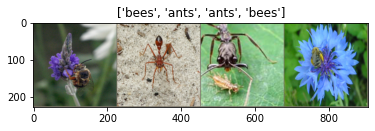

In [3]:
def imshow(inp, title=None):
    # 将输入的类型为torch.tensor的图像数据转为numpy的ndarray格式
    # 由于每个batch的数据是先经过transforms.ToTensor()函数从numpy的ndarray格式转换为torch.tensor格式，这个转换主要是通道顺序上做了调整：
    # 由原始的numpy中的BGR顺序转换为torch中的RGB顺序
    # 所以我们在可视化时候，要先将通道的顺序转换回来，即从RGB转回BGR
    inp = inp.numpy().transpose((1, 2, 0))
    # 接着再进行反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
#  从训练数据中取一个batch的图片
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一个epoch都会进行一次验证
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为验证模式

            running_loss = 0.0
            running_corrects = 0

            #  迭代所有样本
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 将梯度归零
                optimizer.zero_grad()

                # 前向传播网络，仅在训练状态记录参数的梯度从而计算loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播来进行梯度下降
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计loss值
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 依据验证集的准确率来更新最优模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 载入最优模型
    model.load_state_dict(best_model_wts)
    return model
            

In [5]:
# 定义分类loss 
criterion = nn.CrossEntropyLoss()

# 优化器使用sgd，学习率设置为0.001
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 每7个epoch将lr降低为原来的0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 进行训练
cnn_model = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25) 

Epoch 0/24
----------


C:\Users\12759\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6961 Acc: 0.4713
val Loss: 0.6886 Acc: 0.5425

Epoch 1/24
----------
train Loss: 0.6971 Acc: 0.4713
val Loss: 0.6887 Acc: 0.5882

Epoch 2/24
----------
train Loss: 0.6882 Acc: 0.5451
val Loss: 0.6835 Acc: 0.5817

Epoch 3/24
----------
train Loss: 0.6866 Acc: 0.5287
val Loss: 0.6783 Acc: 0.5752

Epoch 4/24
----------
train Loss: 0.6731 Acc: 0.5820
val Loss: 0.6861 Acc: 0.5294

Epoch 5/24
----------
train Loss: 0.6628 Acc: 0.5943
val Loss: 0.6783 Acc: 0.6013

Epoch 6/24
----------
train Loss: 0.6564 Acc: 0.6066
val Loss: 0.6736 Acc: 0.5686

Epoch 7/24
----------
train Loss: 0.6392 Acc: 0.6393
val Loss: 0.6719 Acc: 0.5686

Epoch 8/24
----------
train Loss: 0.6348 Acc: 0.6230
val Loss: 0.6730 Acc: 0.5556

Epoch 9/24
----------
train Loss: 0.6369 Acc: 0.5943
val Loss: 0.6727 Acc: 0.5490

Epoch 10/24
----------
train Loss: 0.6348 Acc: 0.6270
val Loss: 0.6787 Acc: 0.5229

Epoch 11/24
----------
train Loss: 0.6363 Acc: 0.6107
val Loss: 0.6783 Acc: 0.5229

Epoch 12/24
----------
t

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

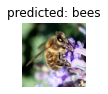

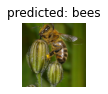

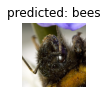

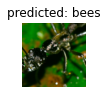

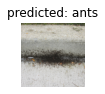

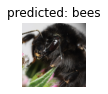

In [7]:
visualize_model(cnn_model)   

In [8]:
# 从torchvision中载入resnet18模型，并且加载预训练
model_conv = torchvision.models.resnet18(pretrained=True)
# freeze前面的卷积层，使其训练时不更新
for param in model_conv.parameters():
    param.requires_grad = False

# 最后的分类fc层输出换为2，进行二分类
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 仅训练最后改变的fc层
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6231 Acc: 0.6557
val Loss: 0.4522 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4481 Acc: 0.7951
val Loss: 0.1911 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.6085 Acc: 0.7541
val Loss: 0.1959 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3308 Acc: 0.8607
val Loss: 0.2061 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4465 Acc: 0.7910
val Loss: 0.1738 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5318 Acc: 0.7746
val Loss: 0.2810 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5042 Acc: 0.8197
val Loss: 0.1973 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4341 Acc: 0.8197
val Loss: 0.2001 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3897 Acc: 0.8197
val Loss: 0.2048 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3708 Acc: 0.8402
val Loss: 0.1897 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3620 Acc: 0.8484
val Loss: 0.1966 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3551 Acc: 0.8320
val Loss: 0.2107 Acc: 0.9281

Ep

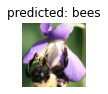

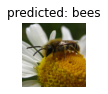

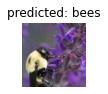

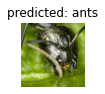

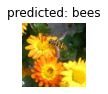

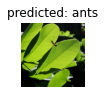

In [10]:
visualize_model(model_ft)

plt.ioff()
plt.show()